In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.optim as optim

## Quelques fonctions utiles

Une fonction pour ajouter du bruit (gaussien ou speckle), deux fonctions pour calculer le SNR et une fonction de normalisation entre 0 et 1.

In [2]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    """
    add_noise ajoute un bruit addition gaussien ou multiplicatif suivant une loi de Gamma.

    :param
    img: image originale
    noise_type: additif gaussien ou spekle suivant une loi de Gamma
    mean: parametre premier ordre
    var: parametre deuxieme ordre

    gaussian: (mean, var)
    gamma: (a, scale)

    :return
    Image bruite.
    """
    row, col = 28, 28
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    """
    Calcul une estimation du SNR.

    :param
    img1: image cible
    img2: image comparatif

    :return
    SNR.
    """
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    """
    Calcul une estimation du PSNR.

    :param
    img1: image cible
    img2: image comparatif

    :return
    PSNR.
    """
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

## Extraction des données et ajout du bruit

Un bruit Gaussien est ajouté à toutes les images des bases de test et d'entraînement.

In [3]:
#Chargement des donnees
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()


#Parametres du bruit
noises = ["gaussian", "speckle"]
#Additif gaussien
mean = 0
var = 10000.
#Gamma spekle
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0    #nombre d'image ayant ete bruitee
noise_id = 0    #0: additif gaussien, 1: Gamma spekle
traindata = np.zeros((60000, 28, 28))

#Ajout du bruit aux images d'entrainement
for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((10000, 28, 28))

#Ajout du bruit au image de test
for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 60000/60000 [00:01<00:00, 49754.69it/s]



gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 49298.30it/s]


gaussian noise addition completed to images


## Affichage d'imagettes

Trois imagettes sont affichées dans leur forme initiale et dans leur forme bruitée

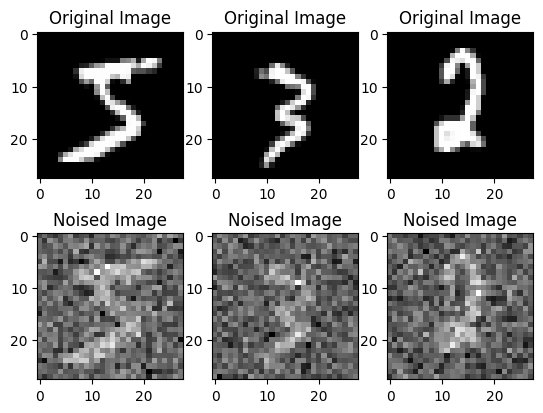

SNR:  0.7171267559422324
PSNR:  18.172129101008416


In [4]:
f, axes = plt.subplots(2, 3)

# Affichage des images original et bruite
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

axes[0, 1].imshow(xtrain[25000], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[25000], cmap="gray")
axes[1, 1].set_title("Noised Image")

axes[0, 2].imshow(xtrain[10100], cmap='gray')
axes[0, 2].set_title("Original Image")
axes[1, 2].imshow(traindata[10100], cmap="gray")
axes[1, 2].set_title("Noised Image")
plt.show()

#Estimation du SNR et du PSNR sur une image
snr_estim = snr(xtrain[0], traindata[0])
psnr_estim = psnr(xtrain[0], traindata[0])

print("SNR: ", snr_estim)
print("PSNR: ", psnr_estim)

## Création de la classe Dataset

In [5]:
class noisedDataset(Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        '''Construction des donnees d'entrainement et de test.'''
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

## Création des Dataloader

Les Dataloaders permettant d'avoir accès aux données pour l'entrainement et le test.

In [6]:
#Construction des donnee
tsfms = transforms.Compose([transforms.ToTensor()])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

batch_size = 32
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

## Création de l'Autoancodeur de Débruitage

La classe contient un encodeur et un décodeur qui permettent le débruitage des images MNIST une fois entrainés.

In [7]:
class denoising_model(nn.Module):
    def __init__(self):
        '''Autoencodeur pour reduction du bruit.'''
        super(denoising_model, self).__init__()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)

        )

        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
        )

    #Autoencoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [8]:
#Creation de l'autoencodeur
from torchsummary import summary

model = denoising_model()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

summary(model, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
              ReLU-6                [-1, 1, 64]               0
            Linear-7               [-1, 1, 128]           8,320
              ReLU-8               [-1, 1, 128]               0
            Linear-9               [-1, 1, 256]          33,024
             ReLU-10               [-1, 1, 256]               0
           Linear-11               [-1, 1, 784]         201,488
          Sigmoid-12               [-1, 1, 784]               0
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
-------------------------------

In [9]:
#Uitlisation du GPU ou du CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

#Hyperparametres.
model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 100
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda


## Entrainement du réseau

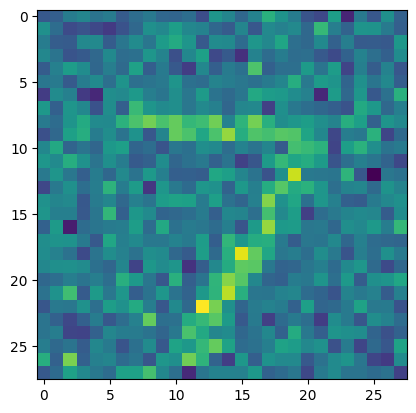

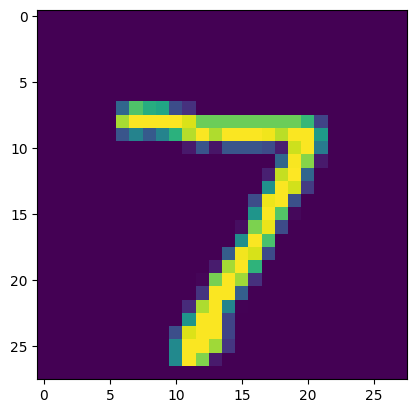

In [10]:
#Mise en forme des donnees de test
image_test = testloader.sampler.data_source.noise[0]
image_test_clean = testloader.sampler.data_source.clean[0]

plt.figure()
plt.imshow(image_test)
plt.figure()
plt.imshow(image_test_clean)

image_test = torch.from_numpy(image_test)
image_test = image_test.view(1, -1).type(torch.FloatTensor)

image_test = image_test.to(device)

Entering Epoch:  0


100%|██████████| 1875/1875 [00:06<00:00, 281.53it/s]


======> epoch: 0/100, Loss:0.07010258734226227
Entering Epoch:  1


100%|██████████| 1875/1875 [00:07<00:00, 266.44it/s]


======> epoch: 1/100, Loss:0.06445153802633286
Entering Epoch:  2


100%|██████████| 1875/1875 [00:07<00:00, 251.70it/s]


======> epoch: 2/100, Loss:0.06625276803970337
Entering Epoch:  3


100%|██████████| 1875/1875 [00:07<00:00, 250.80it/s]


======> epoch: 3/100, Loss:0.06940604746341705
Entering Epoch:  4


100%|██████████| 1875/1875 [00:07<00:00, 259.41it/s]


======> epoch: 4/100, Loss:0.061912018805742264
Entering Epoch:  5


100%|██████████| 1875/1875 [00:06<00:00, 286.93it/s]


======> epoch: 5/100, Loss:0.06392669677734375
Entering Epoch:  6


100%|██████████| 1875/1875 [00:06<00:00, 289.95it/s]


======> epoch: 6/100, Loss:0.060016877949237823
Entering Epoch:  7


100%|██████████| 1875/1875 [00:07<00:00, 257.07it/s]


======> epoch: 7/100, Loss:0.05436859652400017
Entering Epoch:  8


100%|██████████| 1875/1875 [00:06<00:00, 288.33it/s]


======> epoch: 8/100, Loss:0.05609346181154251
Entering Epoch:  9


100%|██████████| 1875/1875 [00:06<00:00, 274.72it/s]


======> epoch: 9/100, Loss:0.052796702831983566
Entering Epoch:  10


100%|██████████| 1875/1875 [00:06<00:00, 286.96it/s]


======> epoch: 10/100, Loss:0.05507553741335869
Entering Epoch:  11


100%|██████████| 1875/1875 [00:05<00:00, 317.45it/s]


======> epoch: 11/100, Loss:0.050245046615600586
Entering Epoch:  12


100%|██████████| 1875/1875 [00:06<00:00, 284.83it/s]


======> epoch: 12/100, Loss:0.050020646303892136
Entering Epoch:  13


100%|██████████| 1875/1875 [00:06<00:00, 289.54it/s]


======> epoch: 13/100, Loss:0.0541861392557621
Entering Epoch:  14


100%|██████████| 1875/1875 [00:06<00:00, 276.75it/s]


======> epoch: 14/100, Loss:0.045660726726055145
Entering Epoch:  15


100%|██████████| 1875/1875 [00:06<00:00, 298.15it/s]


======> epoch: 15/100, Loss:0.04297158122062683
Entering Epoch:  16


100%|██████████| 1875/1875 [00:06<00:00, 285.65it/s]


======> epoch: 16/100, Loss:0.043541502207517624
Entering Epoch:  17


100%|██████████| 1875/1875 [00:06<00:00, 298.01it/s]


======> epoch: 17/100, Loss:0.038350075483322144
Entering Epoch:  18


100%|██████████| 1875/1875 [00:06<00:00, 273.31it/s]


======> epoch: 18/100, Loss:0.04437292739748955
Entering Epoch:  19


100%|██████████| 1875/1875 [00:06<00:00, 282.04it/s]


======> epoch: 19/100, Loss:0.04480259120464325
Entering Epoch:  20


100%|██████████| 1875/1875 [00:06<00:00, 288.47it/s]


======> epoch: 20/100, Loss:0.04403815045952797
Entering Epoch:  21


100%|██████████| 1875/1875 [00:06<00:00, 311.28it/s]


======> epoch: 21/100, Loss:0.04369381442666054
Entering Epoch:  22


100%|██████████| 1875/1875 [00:06<00:00, 292.02it/s]


======> epoch: 22/100, Loss:0.03761184960603714
Entering Epoch:  23


100%|██████████| 1875/1875 [00:06<00:00, 288.07it/s]


======> epoch: 23/100, Loss:0.04072859138250351
Entering Epoch:  24


100%|██████████| 1875/1875 [00:06<00:00, 271.73it/s]


======> epoch: 24/100, Loss:0.036413371562957764
Entering Epoch:  25


100%|██████████| 1875/1875 [00:06<00:00, 295.24it/s]


======> epoch: 25/100, Loss:0.04018762707710266
Entering Epoch:  26


100%|██████████| 1875/1875 [00:06<00:00, 283.49it/s]


======> epoch: 26/100, Loss:0.0366184376180172
Entering Epoch:  27


100%|██████████| 1875/1875 [00:06<00:00, 292.85it/s]


======> epoch: 27/100, Loss:0.03727297484874725
Entering Epoch:  28


100%|██████████| 1875/1875 [00:06<00:00, 272.42it/s]


======> epoch: 28/100, Loss:0.03635966405272484
Entering Epoch:  29


100%|██████████| 1875/1875 [00:06<00:00, 278.60it/s]


======> epoch: 29/100, Loss:0.03746090829372406
Entering Epoch:  30


100%|██████████| 1875/1875 [00:06<00:00, 277.98it/s]


======> epoch: 30/100, Loss:0.038138654083013535
Entering Epoch:  31


100%|██████████| 1875/1875 [00:06<00:00, 300.24it/s]


======> epoch: 31/100, Loss:0.03603436425328255
Entering Epoch:  32


100%|██████████| 1875/1875 [00:06<00:00, 284.26it/s]


======> epoch: 32/100, Loss:0.0302854236215353
Entering Epoch:  33


100%|██████████| 1875/1875 [00:06<00:00, 284.67it/s]


======> epoch: 33/100, Loss:0.03348606079816818
Entering Epoch:  34


100%|██████████| 1875/1875 [00:06<00:00, 277.68it/s]


======> epoch: 34/100, Loss:0.04111821576952934
Entering Epoch:  35


100%|██████████| 1875/1875 [00:06<00:00, 276.48it/s]


======> epoch: 35/100, Loss:0.03519495949149132
Entering Epoch:  36


100%|██████████| 1875/1875 [00:06<00:00, 288.43it/s]


======> epoch: 36/100, Loss:0.034439656883478165
Entering Epoch:  37


100%|██████████| 1875/1875 [00:06<00:00, 284.51it/s]


======> epoch: 37/100, Loss:0.03318479657173157
Entering Epoch:  38


100%|██████████| 1875/1875 [00:06<00:00, 275.90it/s]


======> epoch: 38/100, Loss:0.035606272518634796
Entering Epoch:  39


100%|██████████| 1875/1875 [00:06<00:00, 278.39it/s]


======> epoch: 39/100, Loss:0.03706391900777817
Entering Epoch:  40


100%|██████████| 1875/1875 [00:06<00:00, 274.75it/s]


======> epoch: 40/100, Loss:0.030263273045420647
Entering Epoch:  41


100%|██████████| 1875/1875 [00:06<00:00, 285.02it/s]


======> epoch: 41/100, Loss:0.0335175059735775
Entering Epoch:  42


100%|██████████| 1875/1875 [00:06<00:00, 299.24it/s]


======> epoch: 42/100, Loss:0.03285931423306465
Entering Epoch:  43


100%|██████████| 1875/1875 [00:06<00:00, 280.66it/s]


======> epoch: 43/100, Loss:0.0331287756562233
Entering Epoch:  44


100%|██████████| 1875/1875 [00:06<00:00, 276.58it/s]


======> epoch: 44/100, Loss:0.029506264254450798
Entering Epoch:  45


100%|██████████| 1875/1875 [00:06<00:00, 273.82it/s]


======> epoch: 45/100, Loss:0.03341067582368851
Entering Epoch:  46


100%|██████████| 1875/1875 [00:06<00:00, 293.84it/s]


======> epoch: 46/100, Loss:0.03146765008568764
Entering Epoch:  47


100%|██████████| 1875/1875 [00:06<00:00, 287.32it/s]


======> epoch: 47/100, Loss:0.033114854246377945
Entering Epoch:  48


100%|██████████| 1875/1875 [00:06<00:00, 279.14it/s]


======> epoch: 48/100, Loss:0.031038422137498856
Entering Epoch:  49


100%|██████████| 1875/1875 [00:06<00:00, 270.10it/s]


======> epoch: 49/100, Loss:0.030214566737413406
Entering Epoch:  50


100%|██████████| 1875/1875 [00:06<00:00, 269.53it/s]


======> epoch: 50/100, Loss:0.028323935344815254
Entering Epoch:  51


100%|██████████| 1875/1875 [00:06<00:00, 292.23it/s]


======> epoch: 51/100, Loss:0.02886492758989334
Entering Epoch:  52


100%|██████████| 1875/1875 [00:06<00:00, 290.41it/s]


======> epoch: 52/100, Loss:0.02971857413649559
Entering Epoch:  53


100%|██████████| 1875/1875 [00:06<00:00, 289.49it/s]


======> epoch: 53/100, Loss:0.02841019630432129
Entering Epoch:  54


100%|██████████| 1875/1875 [00:07<00:00, 266.90it/s]


======> epoch: 54/100, Loss:0.0307503379881382
Entering Epoch:  55


100%|██████████| 1875/1875 [00:06<00:00, 283.42it/s]


======> epoch: 55/100, Loss:0.02767888270318508
Entering Epoch:  56


100%|██████████| 1875/1875 [00:06<00:00, 282.98it/s]


======> epoch: 56/100, Loss:0.026914123445749283
Entering Epoch:  57


100%|██████████| 1875/1875 [00:06<00:00, 291.15it/s]


======> epoch: 57/100, Loss:0.02757725678384304
Entering Epoch:  58


100%|██████████| 1875/1875 [00:06<00:00, 281.65it/s]


======> epoch: 58/100, Loss:0.02804609201848507
Entering Epoch:  59


100%|██████████| 1875/1875 [00:06<00:00, 272.89it/s]


======> epoch: 59/100, Loss:0.028933383524417877
Entering Epoch:  60


100%|██████████| 1875/1875 [00:06<00:00, 274.30it/s]


======> epoch: 60/100, Loss:0.03183458372950554
Entering Epoch:  61


100%|██████████| 1875/1875 [00:06<00:00, 278.20it/s]


======> epoch: 61/100, Loss:0.02734406106173992
Entering Epoch:  62


100%|██████████| 1875/1875 [00:06<00:00, 305.24it/s]


======> epoch: 62/100, Loss:0.02823054790496826
Entering Epoch:  63


100%|██████████| 1875/1875 [00:06<00:00, 309.51it/s]


======> epoch: 63/100, Loss:0.030938779935240746
Entering Epoch:  64


100%|██████████| 1875/1875 [00:06<00:00, 296.70it/s]


======> epoch: 64/100, Loss:0.03167318180203438
Entering Epoch:  65


100%|██████████| 1875/1875 [00:07<00:00, 262.09it/s]


======> epoch: 65/100, Loss:0.02892969362437725
Entering Epoch:  66


100%|██████████| 1875/1875 [00:06<00:00, 311.25it/s]


======> epoch: 66/100, Loss:0.028229864314198494
Entering Epoch:  67


100%|██████████| 1875/1875 [00:06<00:00, 302.41it/s]


======> epoch: 67/100, Loss:0.02855733409523964
Entering Epoch:  68


100%|██████████| 1875/1875 [00:06<00:00, 311.44it/s]


======> epoch: 68/100, Loss:0.025776943191885948
Entering Epoch:  69


100%|██████████| 1875/1875 [00:07<00:00, 264.47it/s]


======> epoch: 69/100, Loss:0.02629425935447216
Entering Epoch:  70


100%|██████████| 1875/1875 [00:06<00:00, 279.04it/s]


======> epoch: 70/100, Loss:0.023723745718598366
Entering Epoch:  71


100%|██████████| 1875/1875 [00:06<00:00, 281.70it/s]


======> epoch: 71/100, Loss:0.024866288527846336
Entering Epoch:  72


100%|██████████| 1875/1875 [00:06<00:00, 290.93it/s]


======> epoch: 72/100, Loss:0.028356188908219337
Entering Epoch:  73


100%|██████████| 1875/1875 [00:06<00:00, 297.10it/s]


======> epoch: 73/100, Loss:0.02762618102133274
Entering Epoch:  74


100%|██████████| 1875/1875 [00:06<00:00, 270.60it/s]


======> epoch: 74/100, Loss:0.02737896516919136
Entering Epoch:  75


100%|██████████| 1875/1875 [00:06<00:00, 282.17it/s]


======> epoch: 75/100, Loss:0.024338755756616592
Entering Epoch:  76


100%|██████████| 1875/1875 [00:06<00:00, 274.76it/s]


======> epoch: 76/100, Loss:0.026594093069434166
Entering Epoch:  77


100%|██████████| 1875/1875 [00:06<00:00, 292.01it/s]


======> epoch: 77/100, Loss:0.026057714596390724
Entering Epoch:  78


100%|██████████| 1875/1875 [00:06<00:00, 288.82it/s]


======> epoch: 78/100, Loss:0.030278939753770828
Entering Epoch:  79


100%|██████████| 1875/1875 [00:06<00:00, 278.00it/s]


======> epoch: 79/100, Loss:0.027834132313728333
Entering Epoch:  80


100%|██████████| 1875/1875 [00:06<00:00, 272.45it/s]


======> epoch: 80/100, Loss:0.026600204408168793
Entering Epoch:  81


100%|██████████| 1875/1875 [00:06<00:00, 268.70it/s]


======> epoch: 81/100, Loss:0.028051035478711128
Entering Epoch:  82


100%|██████████| 1875/1875 [00:06<00:00, 298.32it/s]


======> epoch: 82/100, Loss:0.02870418131351471
Entering Epoch:  83


100%|██████████| 1875/1875 [00:06<00:00, 286.34it/s]


======> epoch: 83/100, Loss:0.024868078529834747
Entering Epoch:  84


100%|██████████| 1875/1875 [00:06<00:00, 277.03it/s]


======> epoch: 84/100, Loss:0.026741795241832733
Entering Epoch:  85


100%|██████████| 1875/1875 [00:07<00:00, 267.15it/s]


======> epoch: 85/100, Loss:0.02835112065076828
Entering Epoch:  86


100%|██████████| 1875/1875 [00:06<00:00, 274.35it/s]


======> epoch: 86/100, Loss:0.027946222573518753
Entering Epoch:  87


100%|██████████| 1875/1875 [00:06<00:00, 310.70it/s]


======> epoch: 87/100, Loss:0.02406994067132473
Entering Epoch:  88


100%|██████████| 1875/1875 [00:06<00:00, 282.99it/s]


======> epoch: 88/100, Loss:0.02189946174621582
Entering Epoch:  89


100%|██████████| 1875/1875 [00:06<00:00, 284.71it/s]


======> epoch: 89/100, Loss:0.022979706525802612
Entering Epoch:  90


100%|██████████| 1875/1875 [00:07<00:00, 266.20it/s]


======> epoch: 90/100, Loss:0.02659778483211994
Entering Epoch:  91


100%|██████████| 1875/1875 [00:06<00:00, 280.49it/s]


======> epoch: 91/100, Loss:0.027913440018892288
Entering Epoch:  92


100%|██████████| 1875/1875 [00:06<00:00, 290.47it/s]


======> epoch: 92/100, Loss:0.026515915989875793
Entering Epoch:  93


100%|██████████| 1875/1875 [00:06<00:00, 285.27it/s]


======> epoch: 93/100, Loss:0.025486178696155548
Entering Epoch:  94


100%|██████████| 1875/1875 [00:06<00:00, 283.79it/s]


======> epoch: 94/100, Loss:0.0224983599036932
Entering Epoch:  95


100%|██████████| 1875/1875 [00:07<00:00, 266.43it/s]


======> epoch: 95/100, Loss:0.02542024478316307
Entering Epoch:  96


100%|██████████| 1875/1875 [00:06<00:00, 275.17it/s]


======> epoch: 96/100, Loss:0.027855372056365013
Entering Epoch:  97


100%|██████████| 1875/1875 [00:06<00:00, 282.09it/s]


======> epoch: 97/100, Loss:0.025376586243510246
Entering Epoch:  98


100%|██████████| 1875/1875 [00:06<00:00, 278.35it/s]


======> epoch: 98/100, Loss:0.026126166805624962
Entering Epoch:  99


100%|██████████| 1875/1875 [00:06<00:00, 287.49it/s]


======> epoch: 99/100, Loss:0.02614304982125759


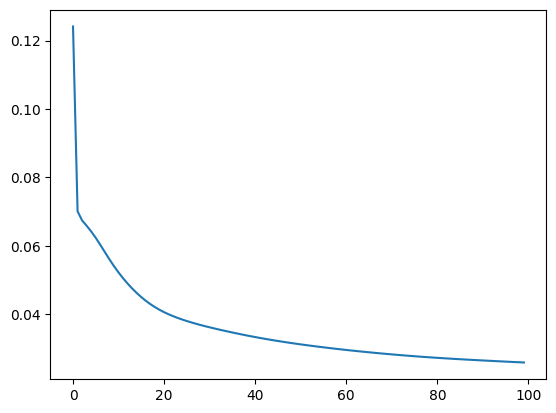

In [11]:
%matplotlib qt

#Entrainement du modele
for epoch in range(epochs):

    print("Entering Epoch: ", epoch)
    for dirty, clean, label in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # En avant
        output = model(dirty)
        loss = criterion(output, clean)
        # En retour
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()

    #Ajout des informations sur une epoch
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))

    image_res = model(image_test)

    image_res = image_res.view(1, 28, 28)
    image_res = image_res.permute(1, 2, 0).squeeze(2)
    image_res = image_res.detach().cpu().numpy()

    plt.imshow(image_res)
    plt.pause(0.01)

    #Enregistrement d'un test sur une image
    plt.savefig(f"animation/{epoch}.png")

%matplotlib inline

plt.plot(range(len(losslist)), losslist)

## Affichage des résultats

Les résultats de 6 éléments de la base de test sont affichés ici. La première colonne correspond à l'image initiale, la seconde l'image bruitée et la troisième l'image reconstruite par l'autoencodeur. La dernière colonne correspond à l'espace latent (entre l'encodeur et le décodeur).

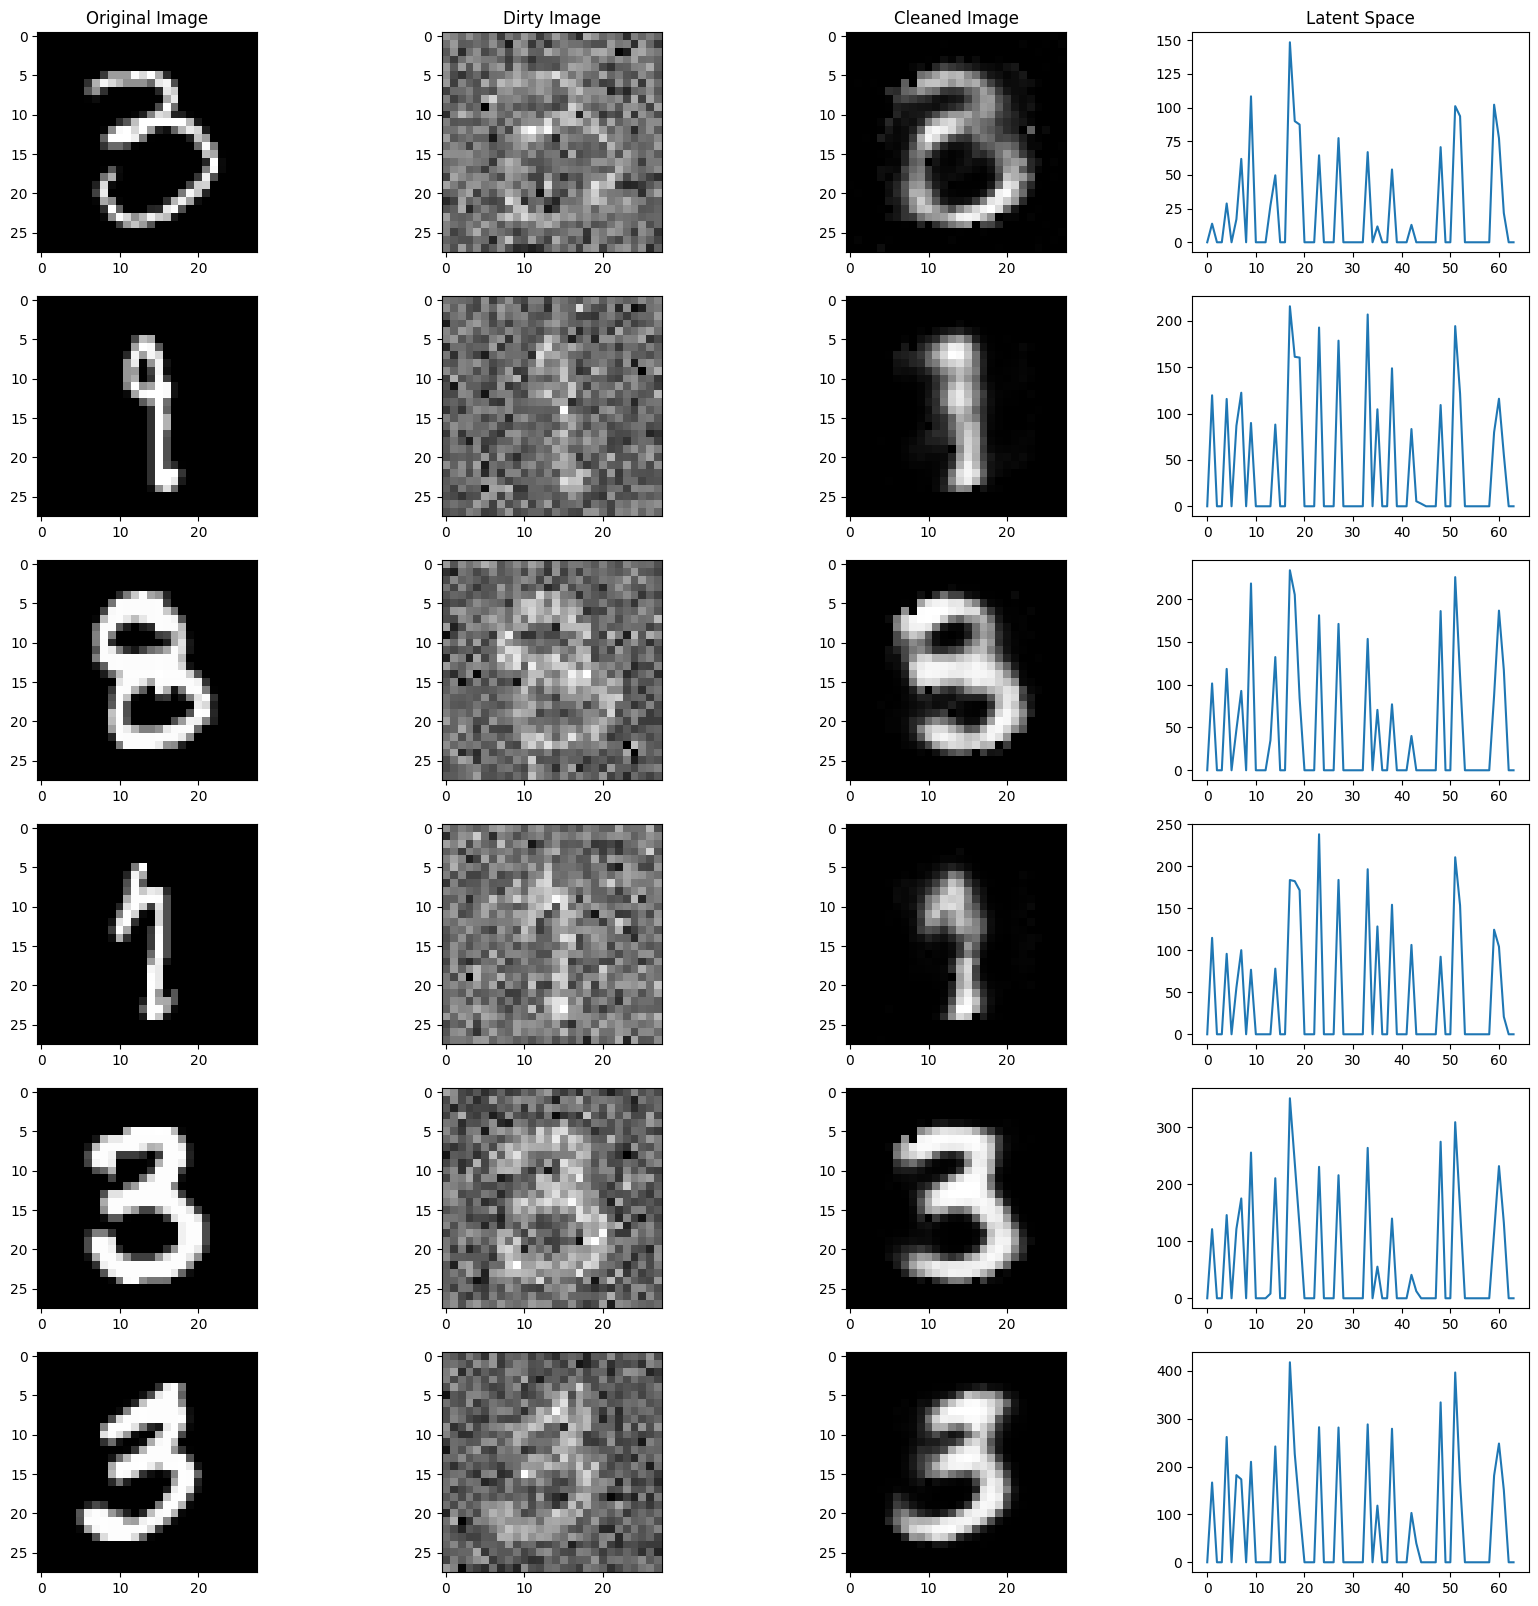

In [12]:
#Ifenrence du modele sur les donnees de test
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 10000, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)
    output_encoder = model.encoder(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(dirty, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    axes[idx, 3].plot(latent)

plt.show()

In [14]:
#Sauvegarde du modele en .pth
PATH = "model/mnistDense.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH

## Génération d'un GIF pour visualiser l'entrainement

In [15]:
import imageio as iio
import numpy as np

#Visualisation d'inference d'une image pour chaque epoch
frames = np.stack([iio.imread(f"animation/{i}.png")[59:425, 105:475] for i in range(50)], axis = 0)

iio.mimwrite('animation_mnist.gif', frames)

C:\Users\gabri\AppData\Local\Temp\ipykernel_8188\431058984.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = np.stack([iio.imread(f"animation/{i}.png")[59:425, 105:475] for i in range(50)], axis = 0)
